In [1]:
# 查看GPU信息
!nvidia-smi

Mon Feb  3 11:29:26 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:03:00.0 Off |                    0 |
| N/A   44C    P0              54W / 400W |      0MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [1]:
from flax import linen as nn

from typing import Sequence

import jax
import jax.numpy as jnp
from jax._src import dtypes

# 正负对称的初始化
def custom_uniform(scale=1e-2, dtype=jnp.float_):
    def init(key, shape, dtype=dtype):
        dtype = dtypes.canonicalize_dtype(dtype)
        return jax.random.uniform(key, shape, dtype, minval=-scale, maxval=scale)
    return init #返回的init输入符合jax接口规范

@jax.jit
def log_cosh(x):
    sgn_x = -2 * jnp.signbit(x.real) + 1
    x = x * sgn_x
    return x + jnp.log1p(jnp.exp(-2.0 * x)) - jnp.log(2.0)

@jax.jit
def attention(J, values, shift):
    values = jnp.roll(values, shift, axis=0)
    return jnp.sum(J * values, axis=0)

class EncoderBlock(nn.Module):
    d_model: int
    h: int
    L: int
    b: int

    def setup(self):
        scale = (3.0 * 0.7 / self.L) ** 0.5
        self.v_projR = nn.Dense(self.d_model, param_dtype=jnp.float64,
                                kernel_init=jax.nn.initializers.variance_scaling(0.3, "fan_in", "uniform"),
                                bias_init=nn.initializers.zeros)
        self.v_projI = nn.Dense(self.d_model, param_dtype=jnp.float64,
                                kernel_init=jax.nn.initializers.variance_scaling(0.3, "fan_in", "uniform"),
                                bias_init=nn.initializers.zeros)
        self.JR = self.param("JR", custom_uniform(scale=scale), (self.L, self.h, 1), jnp.float64)
        self.JI = self.param("JI", custom_uniform(scale=scale), (self.L, self.h, 1), jnp.float64)
        self.W0R = nn.Dense(self.d_model, param_dtype=jnp.float64,
                            kernel_init=jax.nn.initializers.variance_scaling(0.065, "fan_in", "uniform"),
                            bias_init=nn.initializers.zeros)
        self.W0I = nn.Dense(self.d_model, param_dtype=jnp.float64,
                            kernel_init=jax.nn.initializers.variance_scaling(0.065, "fan_in", "uniform"),
                            bias_init=nn.initializers.zeros)

    def __call__(self, x):
        J = self.JR + 1j * self.JI
        x = self.v_projR(x).reshape(self.L, self.h, -1) + 1j * self.v_projI(x).reshape(self.L, self.h, -1)
        x = jax.vmap(attention, (None, None, 0))(J, x, jnp.arange(self.L))
        x = x.reshape(self.L, -1)
        x = self.W0R(x) + 1j * self.W0I(x)
        return log_cosh(x)

class Transformer_Enc(nn.Module):
    d_model: int
    h: int
    L: int
    b: int

    def setup(self):
        self.encoder = EncoderBlock(self.d_model, self.h, self.L, self.b)

    def __call__(self, x):
        x = x.reshape(x.shape[0], -1, self.b)
        x = jax.vmap(self.encoder)(x)
        return jnp.sum(x, axis=(1, 2))

In [2]:
import jax
import jax.numpy as jnp
import netket as nk
import time
from netket.experimental.driver.vmc_srt import VMC_SRt

# 设置JAX使用GPU
jax.config.update("jax_platform_name", "cpu")



# 设置随机种子和参数
seed = 0
L = 16
J2 = 0
diag_shift = 1e-3
eta = 0.005
N_opt = 500
N_samples = 3200
N_discard = 0
f = 1
heads = 8
d_model = f * heads
b = 4


# 创建晶格和Hilbert空间
lattice = nk.graph.Chain(length=L, pbc=True, max_neighbor_order=2)
hilbert = nk.hilbert.Spin(s=1/2, N=lattice.n_nodes, total_sz=0)
hamiltonian = nk.operator.Heisenberg(hilbert=hilbert, graph=lattice, J=[1.0, J2])



# 初始化变分波函数和采样器
wf = Transformer_Enc(d_model=d_model, h=heads, L=L // b, b=b)
key = jax.random.PRNGKey(seed)
key, subkey = jax.random.split(key, num=2)
params = wf.init(subkey, jnp.zeros((1, lattice.n_nodes)))
sampler = nk.sampler.MetropolisExchange(hilbert=hilbert, graph=lattice, d_max=2, 
                                       n_chains=N_samples, sweep_size=lattice.n_nodes)
key, subkey = jax.random.split(key, 2)
vstate = nk.vqs.MCState(sampler=sampler, model=wf, sampler_seed=subkey, 
                        n_samples=N_samples, n_discard_per_chain=N_discard, variables=params)
print('Number of parameters = ', nk.jax.tree_size(vstate.parameters))



optimizer = nk.optimizer.Sgd(learning_rate=eta)
# optimizer = nk.optimizer.Adam(learning_rate=eta)

# 创建VMC驱动器
vmc = VMC_SRt(hamiltonian=hamiltonian, optimizer=optimizer, diag_shift=diag_shift, variational_state=vstate)



# 优化过程
start = time.time()
vmc.run(out='ViT', n_iter=N_opt)
end = time.time()
print('The calculation took ', end - start, ' seconds')

# 获取并打印优化后的能量
energy = vstate.expect(hamiltonian).mean
print('The optimized energy is E0 = ', energy / (4 * L))

Tue Jan 28 08:18:35 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:03:00.0 Off |                    0 |
| N/A   45C    P0              57W / 400W |  30814MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Number of parameters =  288


/var/tmp/pbs.9329445.pbs101/ipykernel_1767340/3386191990.py:54: UnoptimalSRtWarning: 
You are in the case n_samples > num_params (3200 > 288),
for which the `VMC_SRt` is not optimal. Consider using `netket.driver.VMC`
with the preconditioner `nk.optimizer.SR` to achieve the same parameter dynamics,
but with improved speed.


-------------------------------------------------------
For more detailed informations, visit the following link:
	 https://netket.readthedocs.io/en/latest/api/_generated/errors/netket.errors.UnoptimalSRtWarning.html
or the list of all common errors and warnings at
	 https://netket.readthedocs.io/en/latest/api/errors.html
-------------------------------------------------------

  vmc = VMC_SRt(hamiltonian=hamiltonian, optimizer=optimizer, diag_shift=diag_shift, variational_state=vstate)


  0%|          | 0/500 [00:00<?, ?it/s]

The calculation took  22.672118186950684  seconds
The optimized energy is E0 =  (-0.44576408427928516-0.0002436897174283934j)


2025-01-28 08:19:10.689844: W external/xla/xla/service/gpu/ir_emitter_unnested.cc:1171] Unable to parse backend config for custom call: Could not convert JSON string to proto: : Root element must be a message.
Fall back to parse the raw backend config str.
2025-01-28 08:19:10.689892: W external/xla/xla/service/gpu/ir_emitter_unnested.cc:1171] Unable to parse backend config for custom call: Could not convert JSON string to proto: : Root element must be a message.
Fall back to parse the raw backend config str.
2025-01-28 08:19:10.707679: W external/xla/xla/service/gpu/ir_emitter_unnested.cc:1171] Unable to parse backend config for custom call: Could not convert JSON string to proto: : Root element must be a message.
Fall back to parse the raw backend config str.
2025-01-28 08:19:10.707707: W external/xla/xla/service/gpu/ir_emitter_unnested.cc:1171] Unable to parse backend config for custom call: Could not convert JSON string to proto: : Root element must be a message.
Fall back to parse 

The exact ground-state energy is E0 =  -0.4463935225385482


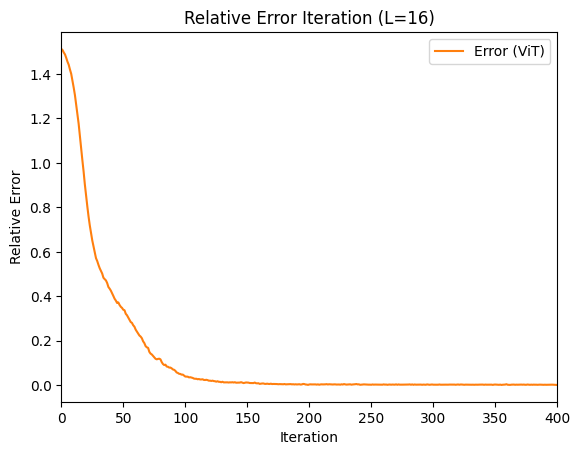

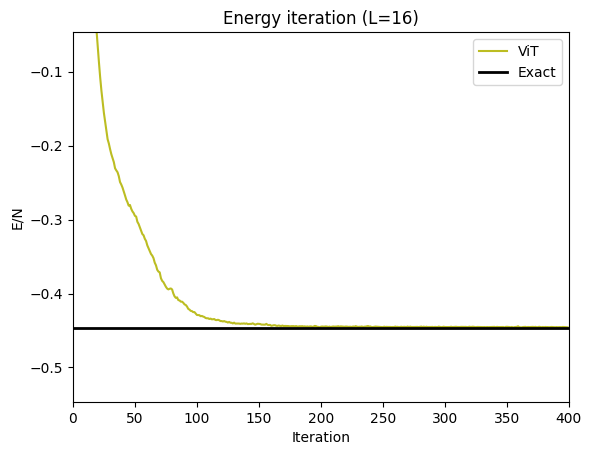

In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np

# 加载和处理优化日志数据
data_ViT = json.load(open('ViT.log'))
min_iter = 0
max_iter = 400
iters_ViT = data_ViT['Energy']['iters'][min_iter:max_iter]
energy_ViT = [e / (4 * L) for e in data_ViT['Energy']['Mean']['real'][min_iter:max_iter]]

# 计算基态能量（适用于L ≤ 16）
if L <= 16:
    evals = nk.exact.lanczos_ed(hamiltonian, compute_eigenvectors=False)
    exact_gs_energy = evals[0] / (4 * L)
    print('The exact ground-state energy is E0 = ', exact_gs_energy)
    error_ViT = [np.abs((e - exact_gs_energy) / exact_gs_energy) for e in energy_ViT]
    fig, ax2 = plt.subplots()
    ax2.plot(iters_ViT, error_ViT, color='C1', label='Error (ViT)')
    ax2.set_ylabel('Relative Error')
    ax2.set_xlabel('Iteration')
    ax2.set_title(f'Relative Error Iteration (L={L})')
    ax2.set_xlim([0, max_iter])
    ax2.legend()


# 绘制能量迭代图
fig, ax1 = plt.subplots()
ax1.plot(iters_ViT, energy_ViT, color='C8', label='ViT')
ax1.set_ylabel('E/N')
ax1.set_xlabel('Iteration')
ax1.set_title(f'Energy iteration (L={L})')

if 'exact_gs_energy' in locals():
    plt.axis([0, max_iter, exact_gs_energy - 0.1, exact_gs_energy + 0.4])
    plt.axhline(y=exact_gs_energy, xmin=0, xmax=max_iter, linewidth=2, color='k', label='Exact')
ax1.legend()

# 绘制相对误差迭代图


plt.show()

2025-01-28 08:19:11.576240: W external/xla/xla/service/gpu/ir_emitter_unnested.cc:1171] Unable to parse backend config for custom call: Could not convert JSON string to proto: : Root element must be a message.
Fall back to parse the raw backend config str.
2025-01-28 08:19:11.576275: W external/xla/xla/service/gpu/ir_emitter_unnested.cc:1171] Unable to parse backend config for custom call: Could not convert JSON string to proto: : Root element must be a message.
Fall back to parse the raw backend config str.
2025-01-28 08:19:13.406176: W external/xla/xla/service/gpu/ir_emitter_unnested.cc:1171] Unable to parse backend config for custom call: Could not convert JSON string to proto: : Root element must be a message.
Fall back to parse the raw backend config str.
2025-01-28 08:19:13.406214: W external/xla/xla/service/gpu/ir_emitter_unnested.cc:1171] Unable to parse backend config for custom call: Could not convert JSON string to proto: : Root element must be a message.
Fall back to parse 

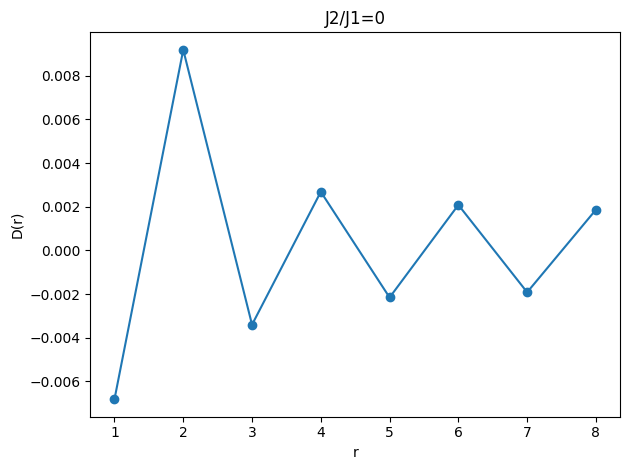

In [4]:
# 定义二点和四点算符
def build_2site_operator(hilbert, graph):
    op = nk.operator.LocalOperator(hilbert)
    L = graph.n_nodes
    for R in range(L):
        R1 = (R + 1) % L
        Sz_R = nk.operator.spin.sigmaz(hilbert, R)
        Sz_R1 = nk.operator.spin.sigmaz(hilbert, R1)
        op += (Sz_R @ Sz_R1)
    return op

def build_4site_operator(hilbert, graph, r):
    op = nk.operator.LocalOperator(hilbert)
    L = graph.n_nodes
    for R in range(L):
        R1 = (R + 1) % L
        Rr = (R + r) % L
        Rr1 = (R + r + 1) % L
        Sz_R = nk.operator.spin.sigmaz(hilbert, R)
        Sz_R1 = nk.operator.spin.sigmaz(hilbert, R1)
        Sz_Rr = nk.operator.spin.sigmaz(hilbert, Rr)
        Sz_Rr1 = nk.operator.spin.sigmaz(hilbert, Rr1)
        op += (Sz_R @ Sz_R1 @ Sz_Rr @ Sz_Rr1)
    return op

# 计算相关函数
two_site_op = build_2site_operator(hilbert, lattice)
Czz1_val = (vstate.expect(two_site_op).mean / L) * 0.25
corr_vals = []
max_r = L // 2
for r in range(1, max_r + 1):
    val_r = (vstate.expect(build_4site_operator(hilbert, lattice, r)).mean / L) * 0.0625
    Dr = val_r - Czz1_val**2
    corr_vals.append(Dr.real)

# 绘制D(r)图
plt.plot(range(1, max_r + 1), corr_vals, marker='o')
plt.xlabel("r")
plt.ylabel("D(r)")
plt.title(f"J2/J1={J2}")
plt.tight_layout()
plt.show()
